# Section 1: Business Understanding

The ability to predict whether a property will be successful on the platform is crucial for both hosts and Airbnb. For hosts, it can help decide if listing the property on Airbnb will be profitable and also allows them to make decisions about policies such as number of guests allowed, price per night, cancellation criteria, etc.

For Airbnb, it allows them to optimize the platform for its users, by providing a better match between guests and properties. Being able to predict the success of a property on Airbnb can help to ensure a positive experience for both hosts and guests, and can play a significant role in the growth and success of the company.

For this analysis I want to answer three questions:

### 1. Which location-related variable generate a more accurate model?

### 2. Can the model be improved by doing a sentiment analysis of the reviews?

### 3. How the accuracy of the model changes with each dimension and what is the final accuracy of the model using all the selected variables?

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import Random Forest Model classifier
from sklearn.ensemble import RandomForestClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
import seaborn as sns
pd.set_option('max_columns', None)
%matplotlib inline

# Section 2: Data Understanding

## Gather data

In [2]:
# Open calendar and listings data
boston_calendar = pd.read_csv("boston_airbnb_data/calendar.csv")
boston_listings = pd.read_csv("boston_airbnb_data/listings.csv")

## Assess data

Use calendar data to calculate the occupancy percentage of each listing, applying the next formula per listing: sum(available “f”)/ sum(available “f”) + sum(available “t”)

In [3]:
# Drop price column because we don't need it for our analysis
boston_calendar = boston_calendar.drop('price', axis=1)
# Get one column for each variable on for t(true) and one for f(false)
boston_calendar = pd.concat([boston_calendar.drop('available', axis=1), pd.get_dummies(boston_calendar['available'], prefix='available', prefix_sep='_')], axis=1)
# Group by each list id by adding the number of times each list_id is available and unavailable
boston_occupation = boston_calendar.groupby("listing_id").sum()
# Add a column with the occupancy percentage, which is the number of days occupied divided by the total number of days registered
boston_occupation["occupation_percentage"] = boston_occupation["available_f"]*100/(boston_occupation["available_f"]+boston_occupation["available_t"])

Plot the data with a histogram to visualize the distribution of the data 

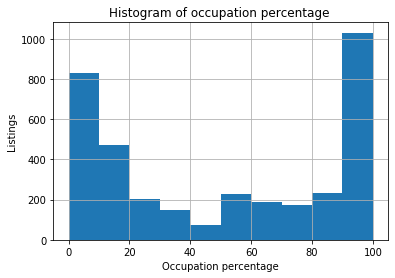

In [4]:
# Create a histrogram 
boston_occupationpercentage_hist = boston_occupation["occupation_percentage"].hist()
boston_occupationpercentage_hist.set_xlabel("Occupation percentage")
boston_occupationpercentage_hist.set_ylabel("Listings")
boston_occupationpercentage_hist.title.set_text('Histogram of occupation percentage ')

The predict variable doesn’t follow a normal distribution and listing data have a lot of categoric variables, also, I want to understand which variables are more relevant to the model. For these reasons and because it tends to provide a high level of accuracy, I chose to use a random forest classifier algorithm.
To use this algorithm first I convert the continuous output variable to categoric. For the use sought, it is not relevant to calculate an exact occupancy percentage, knowing if it has low, medium, or high occupancy may be enough to make business decisions. For this reason, three categories were made for the occupancy percentage, 1 that goes from 0% to 33.33%, 2 that goes from 33.34% to 66.66% and 3 that goes from 66.67% to 100%.

In [5]:
def percentage_to_categorical(value,levels):
    '''
    INPUT
    value - A integer or float value from 0 to 100 
    levels -The number of levels or categories into which the 100 percent will be divided 
    
    OUTPUT
    level - A integer that represent the level or category to which the value belongs
    
    This function return the category to which the value belongs,given the number of levels.
    '''
    # Ensures that the value is float
    value = float(value)
    # Defines the upper limit
    up_limit = 100
    # Defines the value that each range will have
    step = 100/levels
    level = levels
    while level > 0:
        if value <= up_limit and value > (up_limit-step):
            return level
        else:
            level -= 1
            up_limit -= step

In [6]:
# Apply function
boston_occupation["occupation_percentage_categoric"] = boston_occupation["occupation_percentage"].apply(lambda x: percentage_to_categorical(x,3))
# Drop columns will no longer be used
boston_occupation = boston_occupation.drop(["available_f","available_t","occupation_percentage"], axis=1)

The output variable is added to the listings data

In [7]:
# Create a consolidate dataframe with all the listings data and the ocupation percentage
df = pd.merge(boston_listings, boston_occupation,left_on="id",right_on="listing_id", how="inner")

Open the csv file obtained with the function sentiment_comments_todf, rename columns and added to the main data frame that already contains output variable and listings data

In [8]:
# Open the csv file obtained with the function sentiment_comments_todf
boston_sentiment_comments = pd.read_csv("mean_sentiment_comments.csv")
# Rename the columns
boston_sentiment_comments.columns = ['listing_id', 'reviews_sentiment_positive', 'reviews_sentiment_negative',
                                     'reviews_sentiment_neutral','reviews_sentiment_mixed','number_sentiment_reviews']
# Create a consolidate dataframe with all the listings data, the ocupation percentage categoric and the sentiment analysis
df = pd.merge(df, boston_sentiment_comments,left_on="id",right_on="listing_id", how="inner")

In [9]:
# Use describe method to display the type of data by column
df.describe(include="all")

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,occupation_percentage_categoric,listing_id,reviews_sentiment_positive,reviews_sentiment_negative,reviews_sentiment_neutral,reviews_sentiment_mixed,number_sentiment_reviews
count,2.829000e+03,2829,2.829000e+03,2829,2829,2698,2124,2829,2829,1828,1399,1924,1821,1749,2056,2339,2339,2829,2339,2.829000e+03,2829,2829,2829,2820,1931,2593,2593,2593,2829,2829,2829,2579,2829.000000,2829.000000,2829,2829,2829,2829,2418,2829,0.0,2827,2829,2804,2823,2829,2829,2829,2829.000000,2829.000000,2829,2827,2829,2829.000000,2817.000000,2821.000000,2823.000000,2829,2829,54.000000,2829,827,801,1136,2011,2829.000000,2829,2829.000000,2.829000e+03,2829,0.0,2829.000000,2829.000000,2829.000000,2829.000000,2829,2829.00000,2829,2829,2772.000000,2762.000000,2767.000000,2765.000000,2767.000000,2763.000000,2764.000000,2829,0.0,0.0,2829,2829,2829,2829,2829.000000,2829.000000,2829.000000,2.829000e+03,2829.000000,2829.000000,2829.000000,2829.000000,2829.000000
unique,NaN,2829,NaN,1,2776,2497,1952,2734,1,1512,1126,1621,1563,1438,1694,2339,2339,2829,2339,NaN,1776,1121,1143,146,1098,4,46,71,2,1770,1770,49,NaN,NaN,65,2,2,1096,29,25,NaN,33,1,40,3,34,1,1,NaN,NaN,2,12,3,NaN,NaN,NaN,NaN,5,2501,NaN,294,236,276,50,74,NaN,47,NaN,NaN,34,NaN,NaN,NaN,NaN,NaN,1,NaN,975,404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,2,4,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,https://www.airbnb.com/rooms/12368082,NaN,2016-09-07,Lux 2BR by Fenway w/WiFi,"The unit is stylishly designed for comfort, va...",The studio's kitchenette comes equipped with a...,Private room in a HOSTEL exclusive for Airbnb ...,none,Conveniently bordering the neighborhoods of th...,Although we do not allow pets in our apartment...,Located less than a five minute walk to Back B...,"You have access to the entire apartment, and a...",Need more towels? A restaurant recommendation?...,House Rules 1. Check-in is 4 pm local time. If...,https://a2.muscache.com/im/pictures/104991764/...,https://a0.muscache.com/im/pictures/25117872/1...,https://a1.muscache.com/im/pictures/101074586/...,https://a2.muscache.com/im/pictures/2d068066-a...,NaN,https://www.airbnb.com/users/show/25188,Seamless,2009-07-10,"Boston, Massachusetts, United States",ABOUT US:\r\n\r\nSeamlessTransition is a full-...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/25188/profile...,https://a2.muscache.com/im/users/25188/profile...,Allston-Brighton,NaN,NaN,"['email', 'phone', 'reviews', 'jumio']",t,t,"Beacon Street, Boston, MA 02116, United States",Allston-Brighton,Jamaica Plain,NaN,Boston,MA,02116,Boston,"Boston, MA",US,United States,NaN,NaN,t,Apartment,Entire 

The describe method is used to observe the type of data that the dataframe contains and make decisions about which columns to use and which strategies to apply to clean the data.

Column analysis

column: id, dimension: property, strategy: drop - id of the listing <br>
column: listing_url, dimension: none, strategy: drop - out of scope for this analysis <br>
column: scrape_id, dimension: none, strategy: drop - out of scope for this analysis <br>
column: last_scraped, dimension: none, strategy: drop - out of scope for this analysis <br>
column: name, dimension: property, strategy: drop - out of scope for this analysis <br>
column: summary, dimension: property, strategy: drop - out of scope for this analysis <br>
column: space, dimension: property, strategy: drop - out of scope for this analysis <br>
column: description, dimension: property, strategy: drop - out of scope for this analysis <br>
column: experiences_offered, dimension: property, strategy: drop - all values 0 <br>
column: neighborhood_overview, dimension: property, strategy: drop - out of scope for this analysis <br>
column: notes, dimension: property, strategy: drop - out of scope for this analysis <br>
column: transit, dimension: property, strategy: drop - out of scope for this analysis <br>
column: access, dimension: property, strategy: drop - out of scope for this analysis <br>
column: interaction, dimension: property, strategy: drop - out of scope for this analysis <br>
column: house_rules, dimension: property, strategy: drop - out of scope for this analysis <br>
column: thumbnail_url, dimension: property, strategy: drop - out of scope for this analysis <br>
column: medium_url, dimension: property, strategy: drop - out of scope for this analysis <br>
column: picture_url, dimension: property, strategy: drop - out of scope for this analysis <br>
column: xl_picture_url, dimension: property, strategy: drop - out of scope for this analysis <br>
column: host_id, dimension: host, strategy: drop - out of scope for this analysis <br>
column: host_url, dimension: host, strategy: drop - out of scope for this analysis <br>
column: host_name, dimension: host, strategy: drop - out of scope for this analysis <br>
column: host_since, dimension: host, strategy: drop - out of scope for this analysis <br>
column: host_location, dimension: host, strategy: transform to column host in city <br>
column: host_about, dimension: host, strategy: drop - out of scope for this analysis <br>
column: host_response_time, dimension: host, strategy: get dummies <br>
column: host_response_rate, dimension: host, strategy: clear characters to be continuous variable <br>
column: host_acceptance_rate, dimension: host, strategy: clear characters to be continuous variable <br>
column: host_is_superhost, dimension: host, strategy: get dummies <br>
column: host_thumbnail_url, dimension: host, strategy: drop - out of scope for this analysis <br>
column: host_picture_url, dimension: host, strategy: drop - out of scope for this analysis <br>
column: host_neighbourhood, dimension: host, strategy: drop - out of scope for this analysis <br>
column: host_listings_count, dimension: host, strategy: drop - redundant with the following column <br>
column: host_total_listings_count, dimension: host, strategy: none <br>
column: host_verifications, dimension: host, strategy: apply special function to get dummies <br>
column: host_has_profile_pic, dimension: host, strategy: get dummies <br>
column: host_identity_verified, dimension: host, strategy: get dummies <br>
column: street, dimension: property, strategy: drop - out of scope for this analysis <br>
column: neighbourhood, dimension: property, strategy: drop - out of scope for this analysis <br>
column: neighbourhood_cleansed, dimension: property, strategy: get dummies and experiment geographic variables <br>
column: neighbourhood_group_cleansed, dimension: property, strategy: drop - out of scope for this analysis <br>
column: city, dimension: property, strategy: use to filter only properties in Boston and then drop <br>
column: state, dimension: property, strategy: drop - out of scope for this analysis <br>
column: zipcode, dimension: property, strategy: get dummies and experiment geographic variables <br>
column: market, dimension: property, strategy: drop - out of scope for this analysis <br>
column: smart_location, dimension: property, strategy: drop - out of scope for this analysis <br>
column: country_code, dimension: property, strategy: drop - out of scope for this analysis <br>
column: country, dimension: property, strategy: drop - out of scope for this analysis <br>
column: latitude, dimension: property, strategy: drop - none and experiment geographic variables <br>
column: longitude, dimension: property, strategy: drop - none and experiment geographic variables<br>
column: is_location_exact, dimension: property, strategy: drop - out of scope for this analysis <br>
column: property_type, dimension: property, strategy: get dummies <br>
column: room_type, dimension: property, strategy: get dummies <br>
column: accommodates, dimension: property, strategy: none <br>
column: bathrooms, dimension: property, strategy: none <br>
column: bedrooms, dimension: property, strategy: none <br>
column: beds, dimension: property, strategy: none <br>
column: bed_type, dimension: property, strategy: get dummies <br>
column: amenities, dimension: property, strategy: apply special function to get dummies and use in final experiment <br>
column: square_feet, dimension: property, strategy: none <br>
column: price, dimension: property, strategy: clear characters to be continuous variable <br>
column: weekly_price, dimension: property, strategy: drop - is closely related to the price column <br>
column: monthly_price, dimension: property, strategy: drop - is closely related to the price column <br>
column: security_deposit, dimension: property, strategy: clear characters to be continuous variable <br>
column: cleaning_fee, dimension: property, strategy: clear characters to be continuous variable <br>
column: guests_included, dimension: property, strategy: none <br>
column: extra_people, dimension: property, strategy: clear characters to be continuous variable <br>
column: minimum_nights, dimension: property, strategy: none <br>
column: maximum_nights, dimension: property, strategy: none <br>
column: calendar_updated, dimension: property, strategy: drop - out of scope for this analysis <br>
column: has_availability, dimension: property, strategy: Drop because having availability is directly related to having a low occupation percentage <br>
column: availability_30, dimension: property, strategy: Drop because having availability is directly related to having a low occupation percentage <br>
column: availability_60, dimension: property, strategy: Drop because having availability is directly related to having a low occupation percentage <br>
column: availability_90, dimension: property, strategy: Drop because having availability is directly related to having a low occupation percentage <br>
column: availability_365, dimension: property, strategy: Drop because having availability is directly related to having a low occupation percentage <br>
column: calendar_last_scraped, dimension: property, strategy: drop - out of scope for this analysis <br>
column: number_of_reviews, dimension: reviews, strategy: none <br>
column: first_review, dimension: reviews, strategy: drop - out of scope for this analysis <br>
column: last_review, dimension: reviews, strategy: drop - out of scope for this analysis <br>
column: review_scores_rating, dimension: reviews, strategy: none <br>
column: review_scores_accuracy, dimension: reviews, strategy: none <br>
column: review_scores_cleanliness, dimension: reviews, strategy: none <br>
column: review_scores_checkin, dimension: reviews, strategy: none <br>
column: review_scores_communication, dimension: reviews, strategy: none <br>
column: review_scores_location, dimension: reviews, strategy: none <br>
column: review_scores_value, dimension: reviews, strategy: none <br>
column: requires_license, dimension: property, strategy: drop - all values f <br>
column: license, dimension: reviews, property: drop - all values nan <br>
column: jurisdiction_names, dimension: property, strategy: drop - all values nan <br>
column: instant_bookable, dimension: property, strategy: get dummies <br>
column: cancellation_policy, dimension: property, strategy: get dummies <br>
column: require_guest_profile_picture, property: reviews, strategy: get dummies <br>
column: require_guest_phone_verification, dimension: reviews, strategy: get dummies <br>
column: calculated_host_listings_count, dimension: host, strategy: drop - redundant with host_total_listings_count column <br>
column: reviews_per_month, dimension: reviews, strategy: Drop because having more reviews per period of time is directly related to having a high occupation percentage <br>

# Section 3: Data Preparation

## Clean data

Here is a dictionary with all the select columns and the dimension to which they belong, more information about what each column means can be reviewed here: http://insideairbnb.com/get-the-data/

In [10]:
# Selected columns with the dimension to which they belong
columns_for_analysis = {'host_location':'host','host_response_time':'host','host_response_rate':'host',
                        'host_acceptance_rate':'host','host_is_superhost':'host','host_total_listings_count':'host',
                        'host_verifications':'host','host_has_profile_pic':'host','host_identity_verified':'host',
                        'neighbourhood_cleansed':'property','city':'property','zipcode':'property','latitude':'property',
                        'longitude':'property','property_type':'property','room_type':'property','accommodates':'property',
                        'bathrooms':'property','bedrooms':'property','beds':'property','bed_type':'property',
                        'amenities':'property','square_feet':'property','price':'property','security_deposit':'property',
                        'cleaning_fee':'property','guests_included':'property','extra_people':'property',
                        'minimum_nights':'property','maximum_nights':'property','number_of_reviews':'property',
                        'review_scores_rating':'reviews','review_scores_accuracy':'reviews',
                        'review_scores_cleanliness':'reviews','review_scores_checkin':'reviews',
                        'review_scores_communication':'reviews','review_scores_location':'reviews',
                        'review_scores_value':'reviews','requires_license':'property','instant_bookable':'property',
                        'cancellation_policy':'property','require_guest_profile_picture':'property',
                        'require_guest_phone_verification':'property','reviews_sentiment_positive':'reviews',
                        'reviews_sentiment_negative':'reviews','reviews_sentiment_neutral':'reviews',
                        'reviews_sentiment_mixed':'reviews','number_sentiment_reviews':'reviews',
                        'occupation_percentage_categoric':'output'}

In [11]:
# Filter the dataframe with the selected columns
df = df[columns_for_analysis.keys()]
# Filter the city column to leave only the properties that belong to Boston
df = df[df["city"] == "Boston"]
# Drop the city column because it no longer adds variability to the model
df = df.drop("city",axis=1)

In [12]:
# Create a dataframe with the column name and the percent of missing values per column
percent_missing = df.isnull().sum()*100/len(df)

df_nullrows_percent = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing}).reset_index(drop=True)

# Filter and display missing values dataframe
df_nullrows_percent[df_nullrows_percent["percent_missing"]>0].sort_values(by=['percent_missing'],ascending=False)

,column_name,percent_missing
21,square_feet,98.208955
23,security_deposit,60.074627
24,cleaning_fee,28.582090
1,host_response_time,8.358209
2,host_response_rate,8.358209
3,host_acceptance_rate,8.358209
31,review_scores_accuracy,2.388060
35,review_scores_location,2.350746
36,review_scores_value,2.313433
33,review_scores_checkin,2.276119


13 columns have more than 1% missing values, for these columns the following strategies were applied.

-Drop columns: square_feet, security_deposit and cleaning_fee because they have a very high percentage of missing values, and are not critical variables for the analysis<br>
-Review columns, host_response_rate and host_acceptace_rate have two to nine percent of missing values but they are important columns, so they will be filled with the mean<br>
-Host_response_time have 8.3 percent of missing values but is an important column so I will use a dummy nan column for the missing values<br>
-Columns: zipcode,bathrooms,bedrooms,host_location,beds and property_type have a very low percentage of missing values so for those columns the rows that contain nan values will be removed<br>

For host_response_rate, host_acceptance_rate, price and extra people, characters like $ and % must be extracted to convert the values to continuous.

In [13]:
# Drop columns
df = df.drop(["square_feet","security_deposit","cleaning_fee"],axis=1)
# Extract the % sign and transform the value to float.
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '', regex=False).astype(float)
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%', '', regex=False).astype(float)
# Extract the $ and "," sign and transform the value to float
df['price'] = df['price'].str.replace('$', '', regex=False)
df['price'] = df['price'].str.replace(',', '', regex=False)
df['price'] = df['price'].astype(float)
df['extra_people'] = df['extra_people'].str.replace('$', '', regex=False)
df['extra_people'] = df['extra_people'].str.replace(',', '', regex=False)
df['extra_people'] = df['extra_people'].astype(float)
# Apply the fill mean function to the select columns
fill_mean_cols = ["review_scores_accuracy","review_scores_location","review_scores_value","review_scores_checkin",
                 "review_scores_communication","review_scores_cleanliness","review_scores_rating",
                 "host_response_rate","host_acceptance_rate"]

fill_mean = lambda col: col.fillna(col.mean())
df[fill_mean_cols] = df[fill_mean_cols].apply(fill_mean)
# Get dummy columns for host_response_time column including nan values
var = "host_response_time"
df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var],prefix=var, prefix_sep='-', drop_first=True,dummy_na=True)], axis=1)
# Drop the remaining nan values
df = df.dropna()

host_location, this variable has 146 different the values, the most frequent being the city of Boston. Creating dummy variables for each host location will create 146 new columns, and for an Airbnb user doesn’t matter if the host is in Hawaii or Alaska, the only aspect that a user probably cares, is if the host is in the same city as the Airbnb. Because of this, host_location became host_isin_city, a variable that describes if the host lives in Boston or not.

In [14]:
def host_isin_city(host_location):
    '''
    INPUT
    host_location - str value with the location of the host
    
    OUTPUT
    host_isin_city - int 1 or int 0
    
    This function return integer 1 if the host live in Boston, integer 0 if the host does not live in boston.
    '''
    try:
        clean_host_location = host_location.split(",")[0]
        if clean_host_location == "Boston":
            return 1
        else:
            return 0
    except AttributeError:
        return np.nan
    
# Apply function to create new column "host_isin_city"
df['host_isin_city'] = df["host_location"].apply(host_isin_city)
# Drop old column
df = df.drop("host_location",axis=1)

There are two variables: host_verifications and amenities, that have something like a list but that must be cleaned and separated to create dummy columns.

In [15]:
def get_dummies_strlist(df,column_name):
    '''
    INPUT
    df - dataframe to which function will be applied
    column_name - name of the column of the dataframe to which the function will be applied
    
    OUTPUT
    df - dataframe with corresponding dummy columns
    
    This function clean a str with a structure similar to a list or dictionary and return an actual list, 
    then generate a dummy column for each unique element of the list and add the binary value.
    '''

    # Creat a list to save all possible values
    all_items = []
    # Characters to be remove
    replacements = ['"',"'","[","]","{","}"]
    # Loop through all rows in the df
    for index, row in df.iterrows():
        # Select the value based on the column being cleaned
        items = row[column_name]
        # Loop through the characters that need to be removed
        for char in replacements:
            if char in items:
                # Remove the character
                items = items.replace(char,"")
        # Convert already cleaned str value to list
        items = items.split(",")
        # Loop through the items in the list
        for item in items:
            # Check that the item has at least one character
            if len(item) != 0:
                # Clears the item in case it has empty spaces
                clean_item = item.strip()
                clean_item = "{}-{}".format(column_name,clean_item)
                # Check that a column already exists for that item
                if clean_item in df.columns:
                    # If exists assign a value of 1 to that row and column
                    df.loc[index, clean_item] = 1
                else:
                    # If it does not exist create the column and then assign the value of 1 to that row and column
                    df[clean_item] = 0
                    df.loc[index, clean_item] = 1
                    
    # Drop the original column that was transformed
    df = df.drop([column_name], axis=1)
    # Return the new dataframe
    return df

In [16]:
# Apply function to host_verifiations column
df = get_dummies_strlist(df,"host_verifications")

In [17]:
# Apply function to amenities column
df = get_dummies_strlist(df,"amenities")

# Section 4: Evaluate the Results

## Analyze data

To help with our analysis, we created two functions, one to apply the 'get_dummies' function to multiple dataframes, and another to apply the Random Forest Classifier algorithm multiple times per dataframe and average the accuracy score.

In [20]:
def dummi_variables_multipledfs(dfs):
    '''
    INPUT
    dfs - A dictionary with one or more pandas dataframe with categorical variables you want to dummy
    
    OUTPUT
    result_dict - A dictionary with the input pandas dataframes but with dummy columns for each of the categorical columns
    '''
    # Start an empty dictionary
    result_dict = {}
    # Iterate over dictionary keys
    for key in dfs.keys():
        # Extract the pandas dataframe associated with that key
        df = dfs[key]
        # Pull a list of the column names of the categorical variables
        cat_vars = df.select_dtypes(include=['object']).copy().columns
        for var in  cat_vars:
            # For each cat add dummy var, drop original column
            df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var],prefix=var, prefix_sep='-', drop_first=True)], axis=1)
        # Add to the result dictionary the new dataframe with dummy columns 
        result_dict[key]=df
    return result_dict

In [21]:
def experiment_randomforestclassifier(exp_dict,n_repetitions):
    '''
    INPUT
    exp_dict - A dictionary with one or more pandas dataframe
    n_repetitions -Number of times to run Random forest classifier
 
    OUTPUT
    level - A dictionary with the mean accuracy per dataframe obtain with the random forest classifier
    
    '''
    result_dict = {}
    count = 0
    while count < n_repetitions:
        for key in exp_dict.keys():
            df = exp_dict[key]
            #Split data into an X matrix and a response vector y
            y = df['occupation_percentage_categoric']
            x = df.drop('occupation_percentage_categoric', axis=1)
            # Split dataset into training set and test set
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
            #Create a Gaussian Classifier
            rfc=RandomForestClassifier(n_estimators=100,random_state=42)
            #Train the model using the training sets y_pred=clf.predict(X_test)
            rfc.fit(x_train,y_train)
            # Generate prediction
            y_pred=rfc.predict(x_test)
            # Obtain accuracy
            accuracy = metrics.accuracy_score(y_test, y_pred)
            # features
            feature_importance = pd.Series(rfc.feature_importances_,index=list(x.columns)).sort_values(ascending=False)
            # final dict
            try:
                result_dict[key]["accuracy"] += accuracy
            except KeyError:
                result_dict[key] = {"accuracy":accuracy}
        count += 1
        
    # Get the mean, update the result_dict with that value, and graph the results
    x_axis, y_axis = [],[]
    for key in result_dict.keys():
        accuracy_mean = (result_dict[key]["accuracy"])/n_repetitions
        result_dict[key]["accuracy"] = accuracy_mean
        x_axis.append(key)
        y_axis.append(accuracy_mean)
    # Plot the experiment results
    plt.bar(x_axis, y_axis)
    plt.title('Accuracy per experiment')
    plt.xlabel('Experiment')
    plt.ylabel('Accuracy')
    # Get the dowm limit of the y axis
    down_ylim = (math.floor(min(y_axis)*10)/10)
    up_ylim = (math.ceil(max(y_axis)*10)/10)
    plt.ylim(down_ylim,up_ylim)
    plt.show()
    
    return result_dict

### Question 1.	Which location-related variable generate a more accurate model?

For this question there are three possible variables to use: zip code, coordinates (latitude-longitude) and the neighborhood. I create one dataframe per location variable with all the others select variables.

In [ ]:
# Defines the dataframe with only zipcode for location variable
df_with_zipcode = df.drop(['latitude','longitude','neighbourhood_cleansed'],axis=1)
# Defines the dataframe with only coordinates for location variable
df_with_coordinates = df.drop(['zipcode','neighbourhood_cleansed'],axis=1)
# Defines the dataframe with only neighbourhood for location variable
df_with_neighbourhood = df.drop(['zipcode','latitude','longitude'],axis=1)
# Create de experiment dictionary
location_experiment = {"df_with_zipcode":df_with_zipcode,"df_with_coordinates":df_with_coordinates,
                    "df_with_neighbourhood":df_with_neighbourhood}

In [22]:
# Use the function to get dummy columns for each of the categorical columns in all the dataframes
location_experiment = dummi_variables_multipledfs(location_experiment)

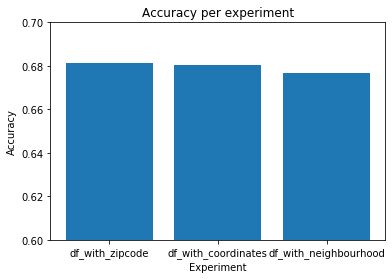

In [23]:
# Use the function to 
location_experiment_results = experiment_randomforestclassifier(location_experiment,40)

The best location-related variable for the model is the coordinates (latitude-longitude) with an accuracy a little above 68%. Although the other values are very close and depending on the use case, they could be more useful, in this case I select the coordinates to have fewer dummy columns and a cleaner model.

In [24]:
location_experiment_results

{'df_with_zipcode': {'accuracy': 0.6812103929024081},
 'df_with_coordinates': {'accuracy': 0.680386565272497},
 'df_with_neighbourhood': {'accuracy': 0.6768694550063372}}

### Question 2. Can the model be improved by doing a sentiment analysis of the reviews?

I create three data frames, one with original review variables and with the sentiment variables (withsentiment), another with only the original review variables (withoutsentiment), and the last one without the original review variables but with the sentiment variables (without_originalreviews).

Just like I did for the location-related variable, I used the random forest classifier algorithm 40 times per data frame, obtain the accuracy of the model and average the values.


In [25]:
# Dataframe with original review variables, sentiment variables, and coordinates as location variable
df_withsentiment = df.drop(['zipcode','neighbourhood_cleansed'],axis=1)
# Dataframe with original review variables and coordinates as location variable
df_withoutsentiment = df.drop(['reviews_sentiment_positive', 'reviews_sentiment_negative','reviews_sentiment_neutral',
                               'reviews_sentiment_mixed','number_sentiment_reviews','zipcode','neighbourhood_cleansed'],axis=1)
# Dataframe with sentiment variables without original review variables and coordinates as location variable
df_without_originalreviews = df.drop(['number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                                      'review_scores_checkin','review_scores_communication','review_scores_location',
                                      'review_scores_value','zipcode','neighbourhood_cleansed'],axis=1)
# Create de experiment dictionary
sentiment_experiment = {'withsentiment':df_withsentiment,'withoutsentiment':df_withoutsentiment,
                             'without_originalreviews':df_without_originalreviews}

In [26]:
sentiment_experiment = dummi_variables_multipledfs(sentiment_experiment)

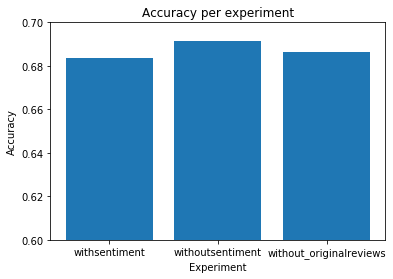

In [27]:
sentiment_experiment_results = experiment_randomforestclassifier(sentiment_experiment,40)

Surprisingly, the best option for the model turned out to be the one containing the original review variables, so sentiment variables do not help to increase the accuracy of the model.

In [28]:
sentiment_experiment_results

{'withsentiment': {'accuracy': 0.6836501901140684},
 'withoutsentiment': {'accuracy': 0.691634980988593},
 'without_originalreviews': {'accuracy': 0.6865019011406844}}

### Question 3. How the accuracy of the model changes with each dimension and what is the final accuracy of the model using all the selected variables?

For this last experiment I used again the random forest classifier algorithm 40 times per data frame, obtain the accuracy of the model and average the values. The data frames used were 4, one for each dimension and lastly one with all the selected variables.

In [ ]:
select_df = sentiment_experiment['withoutsentiment'].copy()

In [124]:
def get_dataframe_perdimension(select_df,columns_for_analysis):
    '''
    INPUT
    select_df - dataframe with the final select columns
    columns_for_analysis - A dictionary with the columns of interest and the dimensions to which they belong
 
    OUTPUT
    df_per_dimension - A pandas datraframe per dimension
    df_column_dimension - A pandas dataframe with the column and the  dimension to which it belongs
    '''
    # Dictionary to add columns per dimension
    columns_per_dimension = {}
    # Loop through dataframe columns
    for dummy in select_df.columns:
        # Obtain the original name of the column before get_dummies
        column = dummy.split("-")[0]
        # Check if the column is in our columns of interest and get its dimension
        if column in columns_for_analysis.keys():
            column_dimension = columns_for_analysis[column]
            # Add the values to the dictionary
            if column_dimension in columns_per_dimension.keys() and column_dimension != "output":
                columns_per_dimension[column_dimension].append(dummy)
            elif column_dimension not in columns_per_dimension.keys() and column_dimension != "output":
                columns_per_dimension[column_dimension] = [dummy,"occupation_percentage_categoric"]

    # Dictionary to add dataframe per dimension
    df_per_dimension = {}
    # Loop through dimensions, get the columns from that dimension and filter the datafrane to add to the dictionaray
    for dimension in columns_per_dimension.keys():
        columns = columns_per_dimension[dimension]
        df = select_df[columns]
        df_per_dimension[dimension] = df

    # List to add the column and the dimension to which it belongs
    column_dimension = []
    # Loop through dimensions, get the columns from that dimension and add the pair value to the list
    for dimension in columns_per_dimension.keys():
        for column in columns_per_dimension[dimension]:
            column_dimension.append([column,dimension])
    # Create a dataframe with the column name and the dimension to which it belongs      
    df_column_dimension = pd.DataFrame(column_dimension, columns = ['column','dimension'])
    # Add the all dimensions dataframe to the df_per_dimension dictionary
    df_per_dimension["all_dimensions"] = select_df

    return df_per_dimension, df_column_dimension

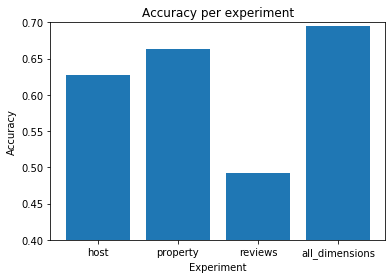

In [126]:
dimension_experiment_results = experiment_randomforestclassifier(df_per_dimension,40)

Reviews are one of the most critical variables when choosing an Airbnb, however in this case they were only able to generate a model with less than 50% accuracy. On the other hand, the type of property and the type of host, by themselves generate a model with an accuracy between 60% and 66% very close to the model that includes all the variables that almost reaches 70 percent accuracy.

In [127]:
dimension_experiment_results

{'host': {'accuracy': 0.6271546261089987},
 'property': {'accuracy': 0.6638149556400507},
 'reviews': {'accuracy': 0.4917300380228137},
 'all_dimensions': {'accuracy': 0.6953105196451204}}

### Final model

For the final model, I used the variables that generated the best result in our analysis, that is: the coordinates for location, the original property reviews without sentiment variables, and the variables from all dimensions.

In [146]:
#Split data into an X matrix and a response vector y
y = select_df['occupation_percentage_categoric']
x = select_df.drop('occupation_percentage_categoric', axis=1)
# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
#Create a Gaussian Classifier
rfc=RandomForestClassifier(n_estimators=100,random_state=42)
#Train the model using the training sets y_pred=clf.predict(X_test)
rfc.fit(x_train,y_train)
# Generate prediction
y_pred=rfc.predict(x_test)
# Obtain accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
# Create a dataframe with the score per column (variable or feature)
feature_importance = pd.DataFrame([list(x.columns),rfc.feature_importances_]).transpose()
feature_importance = feature_importance.rename(columns={1:'score',0:'column'}).sort_values(by='score',ascending=False)
feature_importance = pd.merge(feature_importance,df_column_dimension ,on='column', how="inner")

The final model that includes all the variables almost reaches 70 percent accuracy, which is not a bad value, but considering the output variable is categorical and has only three possible values, it still has a lot of room for improvement

In [147]:
# Final accuracy
accuracy

0.7021546261089987

The score per variable was export to csv to be used in plotly. https://plotly.com/~jordiagv/1/

In [148]:
feature_importance

,column,score,dimension
0,host_total_listings_count,0.058294,host
1,number_of_reviews,0.052172,property
2,latitude,0.052155,property
3,longitude,0.046763,property
4,price,0.045553,property
...,...,...,...
104,property_type-Other,0.000119,property
105,bed_type-Couch,0.000112,property
106,property_type-Boat,0.000091,property
107,property_type-Dorm,0.000084,property


In [149]:
# Export feature importance dataframe to csv
feature_importance.to_csv("feature_importance.csv", index=False)